<a href="https://colab.research.google.com/github/aidenrosebush/ESC472-2023/blob/main/Viewshed_LOS_fast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install tcod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.9 MB/s eta 0:00:00


In [17]:
import tcod
import numpy as np
import matplotlib.pyplot as plt

def getTestPoints(map, point, direction, r):
  testPoints = [] #points on the same side as the ad is facing
  for i in range(0, len(map), 1): 
    for j in range(0, len(map[0]), 1):
      relativeTestPoint = np.array([i-point[0],j-point[1]])
      #if the point is on the right side of the billboard and is within visible range
      if np.dot(relativeTestPoint, direction) >= 0 and np.sqrt(np.dot(relativeTestPoint, relativeTestPoint)) <= r:
        testPoints += [np.array([i,j])]
  return testPoints
def plotTestPoints(map, testPoints):
  fig, ax = plt.subplots()
  coloredMap = np.zeros((len(map), len(map[0])))
  for testPoint in testPoints:
    coloredMap[testPoint[0], testPoint[1]] = 1
  ax.imshow(coloredMap)
  ax.set_title('Test Points')
  return coloredMap
def plotMap(map):
  fig, ax = plt.subplots()
  im = ax.imshow(map)
  ax.set_title('Elevation Map')
  fig.colorbar(im, ax=ax, label='Elevation')
def fitSightLine(map, point, testPoint, elevation):
  # y-y0 = m*(r)
  m = (map[testPoint[0]][testPoint[1]]-elevation)/(np.sqrt(sum((point-testPoint)**2)))
  return m
def getViewshed(map, point, direction, r, elevation):
  point = np.array(point)
  t = getTestPoints(map, point, direction, r)
  plotMap(map)
  coloredMap = plotTestPoints(map, t)

  line = []

  y = 0
  
  for testPoint in t:
    #print(len(t) - y)
    y += 1
    if testPoint[0] != point[0] and testPoint[1] != point[1] and coloredMap[testPoint[0]][testPoint[1]] == 1: #don't consider the ad location itself
      line = tcod.los.bresenham(point,testPoint) #get grid coordinates to search through
      max = -1 #elevation data must bottom out at 0
      m = 0 #store slope of top sightline
      m_test = 0 #store slope of sightline of test point when the test point is not above any point yet seen
      for i in range(1, len(line), 1):
        if coloredMap[line[i][0], line[i][1]] == 1:
          if i == 1:
            m = fitSightLine(map, point, line[1], elevation)
          else:
            m_test = fitSightLine(map, point, line[i], elevation)
            if m_test >= m:
              m = m_test
            else:
              coloredMap[line[i][0], line[i][1]] = 0
      
  return coloredMap
def plotVisiblePoints(coloredMap):
  fig, ax = plt.subplots()
  ax.imshow(coloredMap)
  ax.set_title('Visible Points')
  return
def addBuildingSquare(map, x_left,x_right,y_bottom,y_top, height):
  for x in range(x_left,x_right,1):
    for y in range(y_bottom, y_top, 1):
      map[x][y] = height
  return map
def detectBuildings(buildingMap, coloredMap):
  for i in range(len(coloredMap)):
    for j in range(len(coloredMap[i])):
      if buildingMap[i][j] != 0:
        coloredMap[i][j] = 0
  return coloredMap



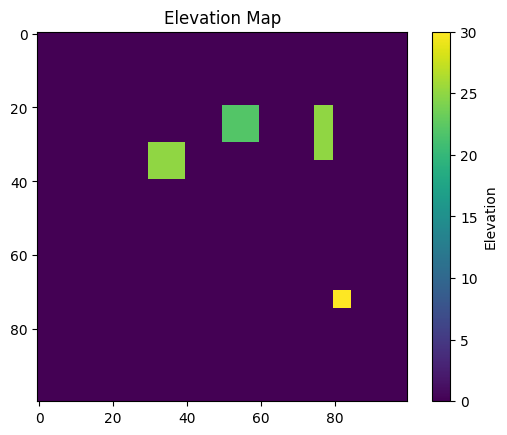

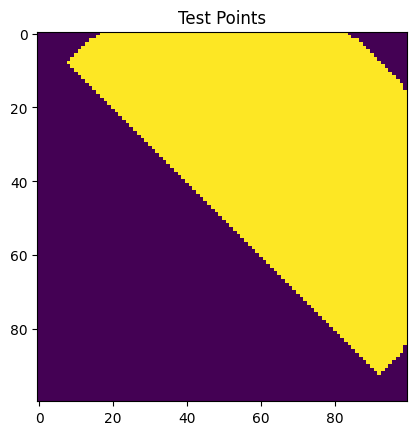

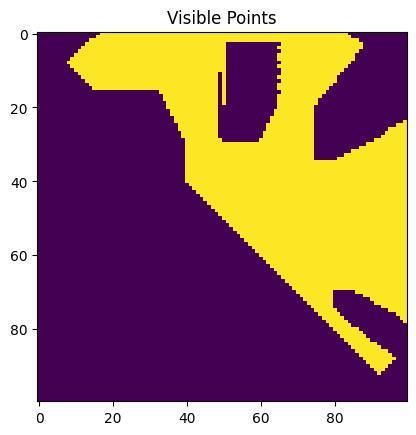

In [22]:
scale = 1
eMap = np.random.uniform(0, 10, (100*scale,100*scale))
eMap = np.zeros((100*scale, 100*scale))
buildingMap = np.zeros((100*scale, 100*scale))
buildingMap = addBuildingSquare(buildingMap, 30*scale,40*scale,30*scale,40*scale,25)
buildingMap = addBuildingSquare(buildingMap, 70*scale,75*scale,80*scale,85*scale,30)
buildingMap = addBuildingSquare(buildingMap, 20*scale,30*scale,50*scale,60*scale,22)
buildingMap = addBuildingSquare(buildingMap, 20*scale,35*scale,75*scale,80*scale,25)
map = eMap + buildingMap
point = [scale*50,scale*50]
direction = [-1,1]
r = 60*scale
elevation = 60
m = getViewshed(map, point, direction, r, elevation)
m = detectBuildings(buildingMap, m)
plotVisiblePoints(m)
